# Historical emissions

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import Image

In [2]:
path_hist = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/*DECK_road_*.nc'
files_hist = glob.glob(path_hist)
files_hist

['/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_aerosol_192001-192912.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_NMVOC_192001-192912.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_MISC_176001-176912.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_NMVOC_201001-201012.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_aerosol_197001-197912.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_MISC_195001-195912.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_NMHC_183001-183912.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_MISC_200001-200912.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_MISC_198001-198912.nc',
 '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_aerosol_193001-1

In [6]:
path_road_misc =  '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v6.1_DLR1.0_DECK_road_MISC_175001-201412.nc'

In [7]:
seconds_in_year = 31536000.
area_earth = 5.1006447295*pow(10,14)
k_to_tera = pow(10, -9)

In [8]:
data_road_misc = xr.open_dataset(path_road_misc)

In [9]:
data_road_misc

<xarray.Dataset>
Dimensions:    (lon: 720, bnds: 2, lat: 360, lev: 1, time: 3180)
Coordinates:
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lev        (lev) float64 45.0
  * time       (time) object 1750-01-16 00:00:00 ... 2014-12-16 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    time_bnds  (time, bnds) object ...
    CO_flux    (time, lev, lat, lon) float32 ...
    NH3_flux   (time, lev, lat, lon) float32 ...
    NOx_flux   (time, lev, lat, lon) float32 ...
    SO2_flux   (time, lev, lat, lon) float32 ...
Attributes: (12/39)
    CDI:                         Climate Data Interface version 1.7.0 (http:/...
    Conventions:                 CF-1.6
    history:                     Tue Aug 28 23:02:02 2018: cdo -O -Q copy /sc...
    source:                      CEDS-2017-08-30: Community Emissions Data Sy...
    institution:                 Pacific Northwest National Laboratory - Join...
    reference1:                  Lamarque et al.(2010), doi:10.5194/acp-10-70...
    ...                          ...
    data_usage_tips:             Note that these are monthly average fluxes.
    reporting_unit:              Mass flux of BC, reported as carbon mass
    nominal_resolution:          50 km
    source_id:                   CEDS-2017-08-30
    tracking_id:                 hdl:21.14100/649247a5-afc6-4e25-b777-9d7a77a...
    CDO:                         Climate Data Operators version 1.7.0 (http:/...

In [10]:
co_flux_road_misc = data_road_misc['CO_flux'] # kg m-2 s-1
nh3_flux_road_misc = data_road_misc['NH3_flux'] # kg m-2 s-1
nox_flux_road_misc = data_road_misc['NOx_flux'] # kg(NO2) m-2 s-1
so2_flux_road_misc = data_road_misc['SO2_flux'] # kg m-2 s-1

In [11]:
def zonal_average(emission):
    # Average over lev
    emission = emission.mean('lev')
    # Create a weight array for the zonal average
    weight_emission = np.cos(np.deg2rad(emission.lat))
    weight_emission = weight_emission / weight_emission.sum() 

    # Average over lon, zonal average over lan
    emission = emission.mean('lon')
    emission_weighted = []
    for year in range(emission.shape[0]):
        emission_year_weighted = np.sum(emission[year, :] * weight_emission).compute().data.item()
        emission_weighted.append(emission_year_weighted)
        
    return emission_weighted 

In [12]:
def total_emissions(flux):
    yearly_flux = zonal_average(flux.resample(time="1YS").mean(dim="time"))  
    return np.array(yearly_flux) * area_earth * seconds_in_year * k_to_tera

In [13]:
co_yearly_flux_road_misc = zonal_average(co_flux_road_misc.resample(time="1YS").mean(dim="time"))  

In [14]:
co_yearly_emissions_road_misc = np.array(co_yearly_flux_road_misc) * area_earth * seconds_in_year * k_to_tera

In [15]:
nox_yearly_emissions_road_misc = total_emissions(nox_flux_road_misc)

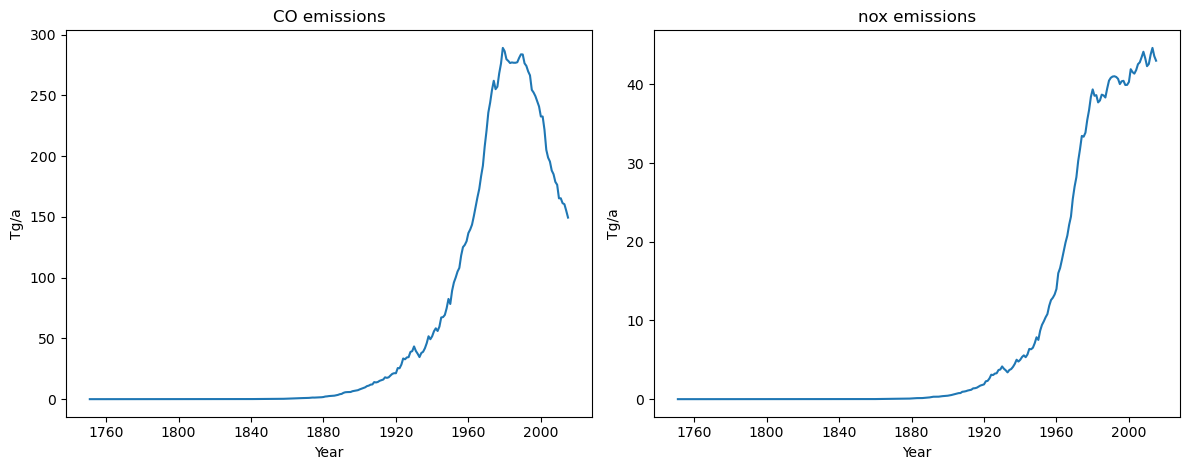

In [16]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)

N = 265
dates = pd.date_range("1/1/1750", periods=265, freq='Y')

axs[0].plot(dates, co_yearly_emissions_road_misc)
axs[0].set_title('CO emissions')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Tg/a')


axs[1].plot(dates, nox_yearly_emissions_road_misc)
axs[1].set_title('nox emissions')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Tg/a')

fig.tight_layout()

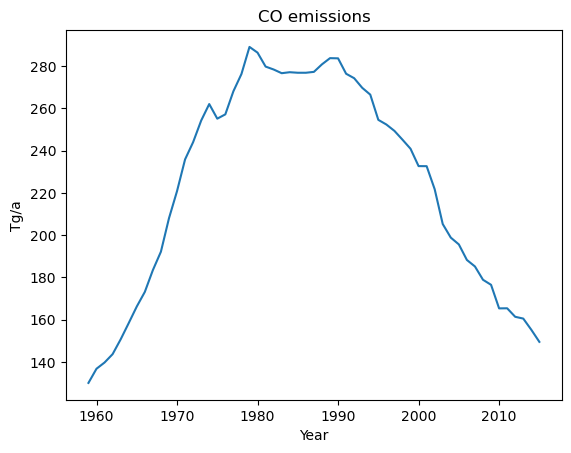

In [19]:
N = 57
dates = pd.date_range("1/1/1958", periods=57, freq='Y')

plt.plot(dates, test)
plt.title('CO emissions')
plt.xlabel('Year')
plt.ylabel('Tg/a')

fig.tight_layout()

In [21]:
road_nox_cams_data = {'NOx': [20.254938, 19.907722, 19.806725, 19.77026, 20.054379, 19.864965, 19.770472, 19.93526, 19.816465, 
             19.135, 19.298807, 19.74603, 20.573029, 20.924507, 21.31049, 21.698856, 21.44433, 21.099398,
             20.825493, 20.567923, 20.377531, 20.099348, 19.887207, 19.652971
            ]
    }
road_nox_cams = pd.DataFrame(data=road_nox_cams_data, index=pd.date_range("1/1/2000", periods=24, freq='Y'))

In [22]:
road_nox_cams

NOx
2000-12-31  20.254938
2001-12-31  19.907722
2002-12-31  19.806725
2003-12-31  19.770260
2004-12-31  20.054379
2005-12-31  19.864965
2006-12-31  19.770472
2007-12-31  19.935260
2008-12-31  19.816465
2009-12-31  19.135000
2010-12-31  19.298807
2011-12-31  19.746030
2012-12-31  20.573029
2013-12-31  20.924507
2014-12-31  21.310490
2015-12-31  21.698856
2016-12-31  21.444330
2017-12-31  21.099398
2018-12-31  20.825493
2019-12-31  20.567923
2020-12-31  20.377531
2021-12-31  20.099348
2022-12-31  19.887207
2023-12-31  19.652971

In [ ]:
def add_index(df,  periods = 150, start_date = "1/1/1950"):
    df.index = pd.date_range("1/1/1950", periods = periods, freq='Y')
    df.columns = ['Date', 'Perturbation A', 'Perturbation B', 'Perturbation C']
    df = df.drop(columns = 'Date')
    return df

In [32]:
cams_file = 'cams-glob-ant-anthro-nox.csv'
cams_data = pd.read_csv(cams_file, sep='\t')
cams_data.columns = ['Date', 'Off Road', 'Road', 'Sum']
cams_data.set_index('Date')

Off Road       Road        Sum
Date                                            
01/01/2000 00:00  1.279055  20.254938  21.533993
01/01/2001 00:00  1.274246  19.907722  21.181968
01/01/2002 00:00  1.276509  19.806725  21.083234
01/01/2003 00:00  1.323127  19.770260  21.093387
01/01/2004 00:00  1.399741  20.054379  21.454120
01/01/2005 00:00  1.487213  19.864965  21.352179
01/01/2006 00:00  1.517617  19.770472  21.288089
01/01/2007 00:00  1.508236  19.935260  21.443496
01/01/2008 00:00  1.403617  19.816465  21.220082
01/01/2009 00:00  1.290227  19.135000  20.425227
01/01/2010 00:00  1.272519  19.298807  20.571326
01/01/2011 00:00  1.413059  19.746030  21.159089
01/01/2012 00:00  1.423738  20.573029  21.996767
01/01/2013 00:00  1.385857  20.924507  22.310364
01/01/2014 00:00  1.398960  21.310490  22.709450
01/01/2015 00:00  1.403518  21.698856  23.102374
01/01/2016 00:00  1.327374  21.444330  22.771704
01/01/2017 00:00  1.287235  21.099398  22.386633
01/01/2018 00:00  1.265572  20.825493  22.091065
01/01/2019 00:00  1.249651  20.567923  21.817574
01/01/2020 00:00  1.239334  20.377531  21.616865
01/01/2021 00:00  1.224181  20.099348  21.323529
01/01/2022 00:00  1.213093  19.887207  21.100300
01/01/2023 00:00  1.207082  19.652971  20.860053

In [34]:
cams_data['Off Road']

0     1.279055
1     1.274246
2     1.276509
3     1.323127
4     1.399741
5     1.487213
6     1.517617
7     1.508236
8     1.403617
9     1.290227
10    1.272519
11    1.413059
12    1.423738
13    1.385857
14    1.398960
15    1.403518
16    1.327374
17    1.287235
18    1.265572
19    1.249651
20    1.239334
21    1.224181
22    1.213093
23    1.207082
Name: Off Road, dtype: float64